In [17]:
%pip install h5py pandas snntorch gymnasium highway-env git+https://github.com/DLR-RM/stable-baselines3 tensorboard torch torchvision

  Cloning https://github.com/DLR-RM/stable-baselines3 to /private/var/folders/0z/k5jkbpg95qn11p7fx9195zxr0000gn/T/pip-req-build-bdurr9a2
  Running command git clone --filter=blob:none --quiet https://github.com/DLR-RM/stable-baselines3 /private/var/folders/0z/k5jkbpg95qn11p7fx9195zxr0000gn/T/pip-req-build-bdurr9a2
  Resolved https://github.com/DLR-RM/stable-baselines3 to commit c8fda060d4bcb283eea6ddd385be5a46a54d3356
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [8]:

import h5py
import pandas as pd
import gymnasium as gym
import highway_env
import stable_baselines3
from sklearn.model_selection import train_test_split
from stable_baselines3 import DQN, DDPG, PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.callbacks import EvalCallback
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools



In [9]:
# Load the h5 file
short_data = 'datasets/short_ppo_data' # 1501 lines
long_data = 'datasets/long_ppo_data' #102,000 lines

with h5py.File(short_data, 'r') as hf:
    car_observations = hf['car tracker'][:]
    lane_observations = hf['lane tracker'][:]
    actions = hf['actions'][:]

actions = actions.flatten()
# Convert to pandas DataFrame
df = pd.DataFrame({
    'car tracker': list(car_observations),
    'lane tracker': list(lane_observations),
    'actions': list(actions)
})

In [7]:
df.head(10)

,car tracker,lane tracker,actions
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",1.000000
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-0.112230
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.005135
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.178478
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.153335
5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.201295
6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-0.641911
7,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-0.397966
8,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-0.451636
9,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-0.110150


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car tracker   1501 non-null   object 
 1   lane tracker  1501 non-null   object 
 2   actions       1501 non-null   float32
dtypes: float32(1), object(2)
memory usage: 29.4+ KB


In [9]:
df["car tracker"][0].shape
df["lane tracker"][0].shape

(12, 12)

# Visualizing Data

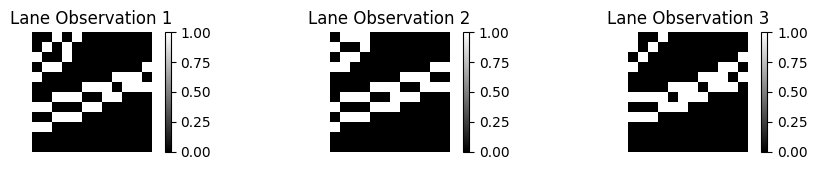

In [10]:
selected_rows = df["lane tracker"][0:3]

plt.figure(figsize=(15, 6))
for idx, row_data in enumerate(selected_rows):
    plt.subplot(4, 5, idx + 1)
    plt.imshow(row_data, cmap='gray')
    plt.colorbar()
    plt.title(f"Lane Observation {idx + 1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


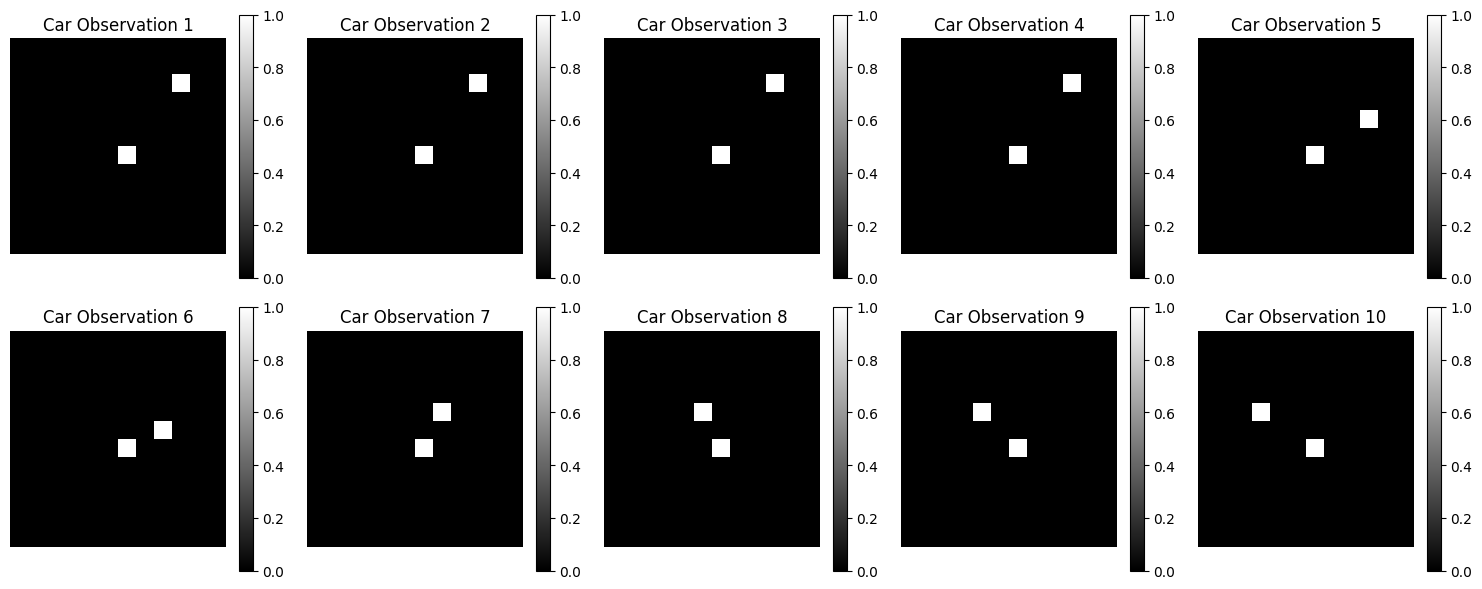

In [11]:
car_found_list = []
for i in range(df['car tracker'].shape[0]):
    if df['car tracker'][i].sum() > 1:
        car_found_list.append(df['car tracker'][i])
selected_rows = car_found_list[30:60:3]

plt.figure(figsize=(15, 6))
for idx, row_data in enumerate(selected_rows):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(row_data, cmap='gray')
    plt.colorbar()
    plt.title(f"Car Observation {idx + 1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# SNNTORCH

In [10]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [11]:
num_steps = 1
batch_size = 1
# Dataset definition with rate encoding
class CustomDataset(Dataset):
    def __init__(self, dataframe, num_steps):
        self.dataframe = dataframe
        self.num_steps = num_steps

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        lane_tracker = torch.tensor(self.dataframe.iloc[idx]['lane tracker']).float()
        lane_tracker = lane_tracker.unsqueeze(0).repeat(self.num_steps, 1, 1)  # Rate encoding
        actions = torch.tensor(self.dataframe.iloc[idx]['actions'])

        return lane_tracker, actions

train_df, test_df = train_test_split(df, test_size=0.2)  # 80% for training, 20% for testing

train_dataset = CustomDataset(train_df, num_steps)
test_dataset = CustomDataset(test_df, num_steps)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


In [12]:
spike_grad = surrogate.fast_sigmoid(slope=25)
# SNN definition
def create_model(beta, threshold):
    net = nn.Sequential(
        nn.Conv2d(1, 8, 3),  # 10x10
        nn.Upsample(scale_factor=2, mode='nearest'),  # 20x20
        snn.Leaky(beta=beta, threshold=threshold, spike_grad=spike_grad, init_hidden=True),

        nn.Conv2d(8, 16, 5),  # 16x16
        snn.Leaky(beta=beta, threshold=threshold, spike_grad=spike_grad, init_hidden=True),

        nn.Flatten(),
        nn.Linear(16 * 16 * 16, 1),
        snn.Leaky(beta=beta, threshold=threshold, spike_grad=spike_grad, init_hidden=True, output=True)
    ).to(device)
    return net


# Forward pass with membrane potential and spike response recording
def forward_pass(net, num_steps, data):
    utils.reset(net)  # resets hidden states for all LIF neurons in net
    spk_out, mem_out = net(data)
    return mem_out

# Test the forward pass and compute the loss for an untrained network
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)
# optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))
loss_hist = []
test_mse_hist = []
def evaluate_regression(model, dataloader, num_steps):
    total_mse = 0.0
    count = 0
    mse_loss = torch.nn.MSELoss()

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            predictions = forward_pass(model, num_steps, data)
            total_mse += mse_loss(predictions, targets).item()
            count += 1

    return total_mse / count


In [14]:
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.3 # Decay rate
threshold = 0.5 # When SNN Spikes
lr = 1e-4 # Learning rate
num_epochs = 10  # Training loop epochs

net = create_model(beta, threshold)

optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        net.train()
        mem_rec = forward_pass(net, num_steps, data)
        loss_val = F.mse_loss(mem_rec, targets)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        running_loss += loss_val.item()
    avg_train_loss = running_loss / len(train_loader)
    loss_hist.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")


print("Finished Training")


/var/folders/0z/k5jkbpg95qn11p7fx9195zxr0000gn/T/ipykernel_1776/1821527571.py:18: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_val = F.mse_loss(mem_rec, targets)


Epoch [1/10], Training Loss: 0.0217
Epoch [2/10], Training Loss: 0.0124
Epoch [3/10], Training Loss: 0.0104
Epoch [4/10], Training Loss: 0.0097
Epoch [5/10], Training Loss: 0.0087
Epoch [6/10], Training Loss: 0.0084
Epoch [7/10], Training Loss: 0.0072
Epoch [8/10], Training Loss: 0.0068
Epoch [9/10], Training Loss: 0.0067
Epoch [10/10], Training Loss: 0.0060
Finished Training


In [15]:
model_path = "snn_model.pth"
torch.save(net.state_dict(), model_path)

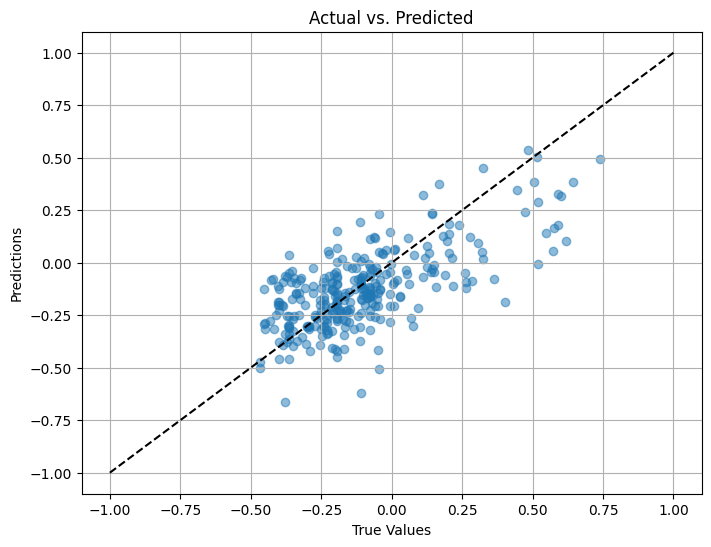

In [16]:
net = create_model(beta, threshold)

# Load the model's state_dict
net.load_state_dict(torch.load(model_path))
net.eval()  # Set the model to evaluation mode

# Test the model on the test set and gather predictions and actual values
all_predictions = []
all_actual = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        _, output_tuple = net(data)
        output = output_tuple[0]
        all_predictions.extend(output.cpu().numpy())
        all_actual.extend(targets.cpu().numpy())

# Convert lists to arrays for plotting
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)

# Plotting Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(all_actual, all_predictions, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([-1, 1], [-1, 1], '--k')  # A diagonal line for reference
plt.grid(True)
plt.show()
